In [161]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import operator

In [162]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance', regression=False): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.regression = regression

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """

        self.training_data = data
        self.training_labels = labels

        return self
    
    def predict(self, data, k, regression=False):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        predictions = []
        for x in data:
          distances = np.zeros((len(self.training_labels),1))
          new_data = np.array(self.training_data, dtype=float)
          new_x = np.array(x, dtype=float)
          distances = np.linalg.norm(new_data - new_x,axis=1)

          distances = np.c_[distances, self.training_labels]
          distances = distances[np.argsort(distances[:,0])]
          neighbors = distances[:k]

          if self.weight_type == 'inverse_distance':

            if regression == False: 
              weighted_votes = {}
              weighted_neighbors = np.zeros_like(neighbors)

              for n in range(neighbors.shape[0]):
                weighted_neighbors[n][0] = 1/neighbors[n][0]**2
                weighted_neighbors[n][1] = neighbors[n][1]

              for wn in weighted_neighbors:
                if wn[1] in weighted_votes:
                  weighted_votes[wn[1]] += wn[0]
                else:
                  weighted_votes[wn[1]] = wn[0]
    
              predictions.append(max(weighted_votes.items(), key=operator.itemgetter(1))[0])
            else:
              values = []
              weights = []
              for i, val in neighbors:
                weight = 1/i**2
                weights.append(weight)
                values.append(val*weight)
              
              predictions.append(np.array(values).sum()/np.array(weights).sum())

          else:
            outputs = [row[-1] for row in neighbors]
            
            if regression == False:
              predictions.append(max(set(outputs), key=outputs.count))
            else:
              values = []
              weights = []
              for i, val in neighbors:
                weights.append(i)
                values.append(val*i)
              
              predictions.append(np.array(values).sum()/np.array(weights).sum())

        return predictions

    #Returns the Mean score given input data and labels
    def score(self, X, y, k, regression=False, mse=False):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """

        
        predictions = np.array(self.predict(X, k, regression))
        if mse == False:
          num_correct = 0
          for i in range(len(predictions)):
            if predictions[i] == y[i]:
              num_correct += 1

          return num_correct/len(y)
        else:
          return np.square(np.subtract(y, predictions)).mean()

In [163]:
## DEBUG SET ##

from scipy.io import arff
import pandas as pd

# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output debug-training-dataset.arff

data = arff.loadarff('debug-training-dataset.arff')
df = pd.DataFrame(data[0])

df['Class'] = [int(s.decode()) for s in df['Class']]

data = np.array(df)
X = data[:,0:-1]
y = df['Class']

debugKNN = KNNClassifier()
debugKNN.fit(X,y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff --output debug-test-dataset.arff

test_data = arff.loadarff('debug-test-dataset.arff')
test_df = pd.DataFrame(test_data[0])

test_df['Class'] = [int(s.decode()) for s in test_df['Class']]

test_data = np.array(test_df)
test_X = test_data[:,0:-1]
test_y = test_df['Class']

accuracy = debugKNN.score(test_X, test_y, 3)

print("\n\nFinal debug accuracy: ", accuracy)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  31333      0 --:--:-- --:--:-- --:--:-- 31333
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9597  100  9597    0     0  48469      0 --:--:-- --:--:-- --:--:-- 48469


Final debug accuracy:  0.9357142857142857


In [164]:
## EVALUATION SET ##

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff --output eval-training-dataset.arff

eval_data = arff.loadarff('eval-training-dataset.arff')
eval_df = pd.DataFrame(eval_data[0])

eval_data = np.array(eval_df)
eval_X = eval_data[:,0:-1]
eval_y = eval_df['class']

evalKNN = KNNClassifier()
evalKNN.fit(eval_X,eval_y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff --output eval-test-dataset.arff

eval_data2 = arff.loadarff('eval-test-dataset.arff')
eval_df2 = pd.DataFrame(eval_data2[0])

eval_data2 = np.array(eval_df2)
eval_X2 = eval_data2[:,0:-1]
eval_y2 = eval_df2['class']

eval_accuracy = evalKNN.score(eval_X2, eval_y2, 3)

print("\n\nFinal evaluation accuracy: ", eval_accuracy)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37419  100 37419    0     0   163k      0 --:--:-- --:--:-- --:--:--  163k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73698  100 73698    0     0   328k      0 --:--:-- --:--:-- --:--:--  328k


Final evaluation accuracy:  0.890625


In [165]:
## PART 2 ##
## 2.1 ##
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output two-training-dataset.arff

p2_data = arff.loadarff('two-training-dataset.arff')
p2_df = pd.DataFrame(p2_data[0])

p2_data = np.array(p2_df)
p2_X = p2_data[:,0:-1]
p2_y = p2_df['class']

p2KNN = KNNClassifier([],'no_weight')
p2KNN.fit(p2_X,p2_y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output two-test-dataset.arff

p2_data2 = arff.loadarff('two-test-dataset.arff')
p2_df2 = pd.DataFrame(p2_data2[0])

p2_data2 = np.array(p2_df2)
p2_X2 = p2_data2[:,0:-1]
p2_y2 = p2_df2['class']

p2_accuracy = p2KNN.score(p2_X2, p2_y2, 3)

print("\n\nFinal 2.1 accuracy: ", p2_accuracy)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  3014k      0 --:--:-- --:--:-- --:--:-- 3014k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  2170k      0 --:--:-- --:--:-- --:--:-- 2170k


Final 2.1 accuracy:  0.8082808280828083


In [166]:
def normalize(X):
  for i in range(X.shape[1]):
    X[:,i] = (X[:,i] - np.min(X[:,i])) / (np.max(X[:,i]) - np.min(X[:,i]))
  return X

In [167]:
## 2.2 ##
norm_p2_X = normalize(p2_X)
norm_p2_X2 = normalize(p2_X2)

normP2KNN = KNNClassifier([], 'no_weight')
normP2KNN.fit(norm_p2_X, p2_y)

norm_p2_accuracy = normP2KNN.score(norm_p2_X2, p2_y2, 3)

print("Final 2.2 accuracy: ", norm_p2_accuracy)

Final 2.2 accuracy:  0.8157815781578158


I was expecting a more significant increase in performance with the normalized data. But it is good that it increased at all, since normalization is supposed to increase performance. 

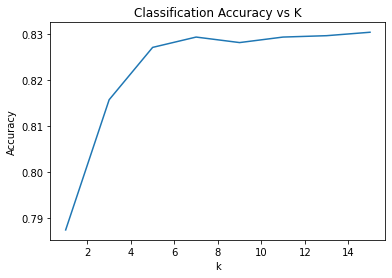

In [168]:
## 2.3 ##
accuracies = []
for k in range(1, 16, 2):
  accuracies.append(normP2KNN.score(norm_p2_X2, p2_y2, k))

ks = [1,3,5,7,9,11,13,15]
plt.title("Classification Accuracy vs K")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.plot(ks, accuracies)

In [169]:
## PART 3 ##
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output three-training-dataset.arff

p3_data = arff.loadarff('three-training-dataset.arff')
p3_df = pd.DataFrame(p3_data[0])

p3_df['CHAS'] = [int(s.decode()) for s in p3_df['CHAS']]

p3_data = np.array(p3_df)
p3_X = p3_data[:,0:-1]
p3_X = normalize(p3_X)
p3_y = p3_df['MEDV']

p3KNN = KNNClassifier([],'no_weight')
p3KNN.fit(p3_X,p3_y)

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output three-test-dataset.arff

p3_data2 = arff.loadarff('three-test-dataset.arff')
p3_df2 = pd.DataFrame(p3_data2[0])

p3_df2['CHAS'] = [int(s.decode()) for s in p3_df2['CHAS']]

p3_data2 = np.array(p3_df2)
p3_X2 = p3_data2[:,0:-1]
p3_X2 = normalize(p3_X2)
p3_y2 = p3_df2['MEDV']

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   168k      0 --:--:-- --:--:-- --:--:--  167k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  22719      0 --:--:-- --:--:-- --:--:-- 22719


In [170]:
mses = []
for k in ks:
  mses.append(p3KNN.score(p3_X2,p3_y2,k,True,True))

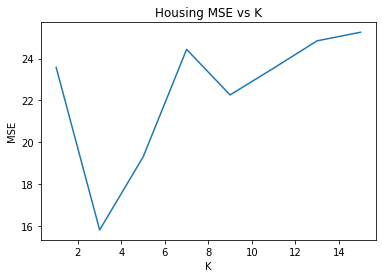

In [171]:
plt.title("Housing MSE vs K")
plt.xlabel("K")
plt.ylabel("MSE")
plt.plot(ks,mses)

In [172]:
## PART 4 ##
teleP4KNN = KNNClassifier([], 'inverse_distance')
teleP4KNN.fit(norm_p2_X, p2_y)

p4_accuracies = []
for k in ks:
  p4_accuracies.append(teleP4KNN.score(norm_p2_X2, p2_y2, k))

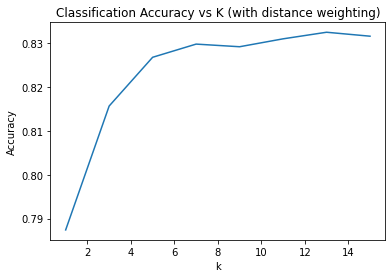

In [173]:
plt.title("Classification Accuracy vs K (with distance weighting)")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.plot(ks, p4_accuracies)

In [174]:
houseP4KNN = KNNClassifier([],'inverse_distance')
houseP4KNN.fit(p3_X,p3_y)

p4_mses = []
for k in ks:
  p4_mses.append(houseP4KNN.score(p3_X2,p3_y2,k,True,True))

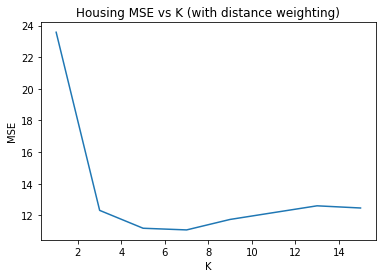

In [175]:
plt.title("Housing MSE vs K (with distance weighting)")
plt.xlabel("K")
plt.ylabel("MSE")
plt.plot(ks,p4_mses)

The telescope dataset performed very similarly with distance weighting. However, the best performance happened at a much higher k value (13, compared to 7 without distance weighting). The max accuracy was around 83.3%, whereas without distance weighting, the max accuracy was 82.9%. This negligible difference means distance weighting may not be worth it (considering the added computational strain) for this dataset.

The housing dataset performed MUCH better with distance weighting. Without it, only one k value (3) yielded a decent MSE (16). However, with distance weighting, not only was the minimum better (11.5), but the average across the different k value was shockingly lower. Distance weighting made the algorithm perform much more consistently and better across different k values. Therefore, distance weighting is most definitely worth doing for this dataset.

In [176]:
## PART 6 ##
skClassifier1 = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto')
tele_p6_y = np.array(p2_y, dtype='str')
skClassifier1.fit(norm_p2_X, tele_p6_y)
tele_p6_y2 = np.array(p2_y2, dtype='str')
accuracy1 = skClassifier1.score(norm_p2_X2, tele_p6_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=3, weights='distance', algorithm='auto'\n", accuracy1)

Accuracy with the following hyperparameters:
n_neighbors=3, weights='distance', algorithm='auto'
 0.8157815781578158


In [177]:
skClassifier2 = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
skClassifier2.fit(norm_p2_X, tele_p6_y)
accuracy2 = skClassifier2.score(norm_p2_X2, tele_p6_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=5, weights='uniform', algorithm='auto'\n", accuracy2)

Accuracy with the following hyperparameters:
n_neighbors=5, weights='uniform', algorithm='auto'
 0.8271827182718272


In [178]:
skClassifier3 = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')
skClassifier3.fit(norm_p2_X, tele_p6_y)
accuracy3 = skClassifier3.score(norm_p2_X2, tele_p6_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=5, weights='distance', algorithm='auto'\n", accuracy3)

Accuracy with the following hyperparameters:
n_neighbors=5, weights='distance', algorithm='auto'
 0.8274827482748275


In [179]:
skClassifier4 = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto')
skClassifier4.fit(norm_p2_X, tele_p6_y)
accuracy4 = skClassifier4.score(norm_p2_X2, tele_p6_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=10, weights='distance', algorithm='auto'\n", accuracy4)

Accuracy with the following hyperparameters:
n_neighbors=10, weights='distance', algorithm='auto'
 0.8303330333033303


The distance weighting does not make as big of a difference as I was expecting, but it seems having more neighbors does. I was able to achieve similar, if not better accuracy with 3 neighbors and distance weighting.

In [180]:
skRegressor1 = KNeighborsRegressor(n_neighbors=3,weights='distance', algorithm='auto')
skRegressor1.fit(p3_X, p3_y)
reg_accuracy1 = skRegressor1.score(p3_X2, p3_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=3, weights='distance', algorithm='auto'\n", reg_accuracy1)

Accuracy with the following hyperparameters:
n_neighbors=3, weights='distance', algorithm='auto'
 0.8312297109129108


In [181]:
skRegressor2 = KNeighborsRegressor(n_neighbors=2,weights='distance', algorithm='auto')
skRegressor2.fit(p3_X, p3_y)
reg_accuracy2 = skRegressor2.score(p3_X2, p3_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=2, weights='distance', algorithm='auto'\n", reg_accuracy2)

Accuracy with the following hyperparameters:
n_neighbors=2, weights='distance', algorithm='auto'
 0.8468857608958766


In [182]:
skRegressor3 = KNeighborsRegressor(n_neighbors=2,weights='uniform', algorithm='auto')
skRegressor3.fit(p3_X, p3_y)
reg_accuracy3 = skRegressor3.score(p3_X2, p3_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=2, weights='uniform', algorithm='auto'\n", reg_accuracy3)

Accuracy with the following hyperparameters:
n_neighbors=2, weights='uniform', algorithm='auto'
 0.8458447338340306


In [183]:
skRegressor4 = KNeighborsRegressor(n_neighbors=2,weights='distance', algorithm='ball_tree')
skRegressor4.fit(p3_X, p3_y)
reg_accuracy4 = skRegressor4.score(p3_X2, p3_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=2, weights='distance', algorithm='ball_tree'\n", reg_accuracy4)

skRegressor5 = KNeighborsRegressor(n_neighbors=2,weights='distance', algorithm='kd_tree')
skRegressor5.fit(p3_X, p3_y)
reg_accuracy5 = skRegressor5.score(p3_X2, p3_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=2, weights='distance', algorithm='kd_tree'\n", reg_accuracy5)

skRegressor6 = KNeighborsRegressor(n_neighbors=2,weights='distance', algorithm='brute')
skRegressor6.fit(p3_X, p3_y)
reg_accuracy6 = skRegressor6.score(p3_X2, p3_y2)
print("Accuracy with the following hyperparameters:\nn_neighbors=2, weights='distance', algorithm='brute'\n", reg_accuracy6)

Accuracy with the following hyperparameters:
n_neighbors=2, weights='distance', algorithm='ball_tree'
 0.8468857608958766
Accuracy with the following hyperparameters:
n_neighbors=2, weights='distance', algorithm='kd_tree'
 0.8468857608958766
Accuracy with the following hyperparameters:
n_neighbors=2, weights='distance', algorithm='brute'
 0.8468857608958763


It's very interesting that the different algorithms yielded basically identical results. There was also almost no difference between distance weighting and no weighting. However, the amount of neighbors made a noticeable difference. It performed better when it was given a smaller k value.